=== Data Preview ===
   Rotational_Speed_rpm  Torque_Nm  Tool_Wear_min  Temperature_C  \
0           1549.671415  53.993554      97.705557      26.146256   
1           1486.173570  49.246337      15.842363      21.428267   
2           1564.768854  40.596304      83.716928      24.280741   
3           1652.302986  33.530632      26.639544      25.602215   
4           1476.584663  46.982233     193.976450      25.367669   

   Machine_Failure  
0                0  
1                0  
2                0  
3                0  
4                0  

=== Class Distribution (Imbalanced) ===
Machine_Failure
0    976
1     24
Name: count, dtype: int64

=== Training set size after SMOTE: 1568 ===

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       192
           1       0.71      0.62      0.67         8

    accuracy                           0.97       200
   macro avg       0.85      0.81      0.83      

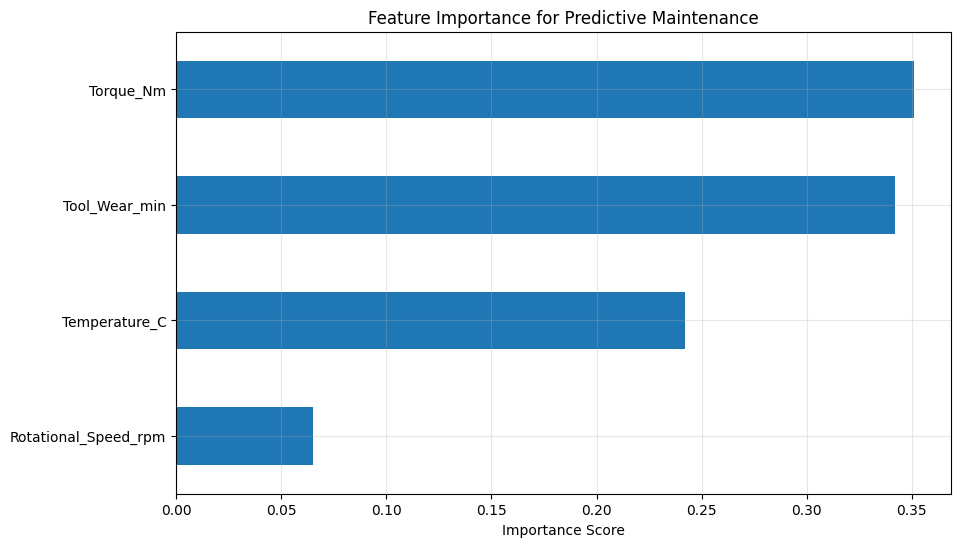

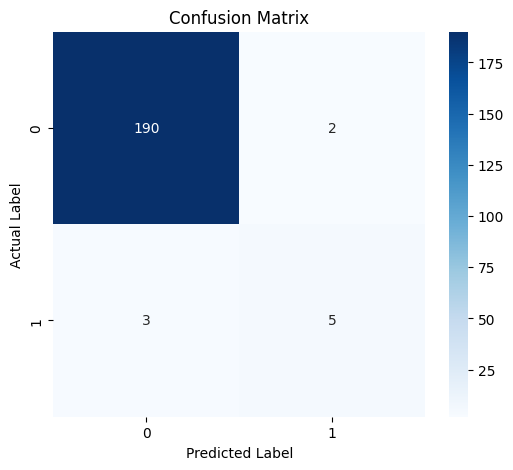

In [1]:
# ==========================================
# Industrial Data Analysis: Predictive Maintenance
# ==========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# 1. Data Simulation
# Generating synthetic sensor data to simulate milling machine operations.
# Features: Rotational Speed, Torque, Tool Wear, Temperature.
np.random.seed(42)
n_samples = 1000
data = {
    'Rotational_Speed_rpm': np.random.normal(1500, 100, n_samples),
    'Torque_Nm': np.random.normal(40, 10, n_samples),
    'Tool_Wear_min': np.random.uniform(0, 240, n_samples),
    'Temperature_C': np.random.normal(25, 2, n_samples)
}
df = pd.DataFrame(data)

# Define failure logic based on physical thresholds
# Failure occurs if (High Torque AND High Wear) OR (High Temperature)
def simulate_failure(row):
    if (row['Torque_Nm'] > 55 and row['Tool_Wear_min'] > 180) or (row['Temperature_C'] > 30):
        return 1 # Failure
    return 0 # Normal

df['Machine_Failure'] = df.apply(simulate_failure, axis=1)

# 2. Data Overview
print("=== Data Preview ===")
print(df.head())
print("\n=== Class Distribution (Imbalanced) ===")
print(df['Machine_Failure'].value_counts())

# 3. Handling Imbalanced Data with SMOTE
# Industrial datasets typically feature rare failure events.
# SMOTE is used to oversample the minority class for better training balance.
X = df.drop('Machine_Failure', axis=1)
y = df['Machine_Failure']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print(f"\n=== Training set size after SMOTE: {len(y_train_res)} ===")

# 4. Model Training (Random Forest)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_res, y_train_res)

# 5. Evaluation
y_pred = model.predict(X_test)
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

# 6. Visualization: Feature Importance
# Identifying which sensor readings contribute most to failure prediction.
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
plt.figure(figsize=(10, 6))
feature_importances.sort_values().plot(kind='barh', color='#1f77b4')
plt.title('Feature Importance for Predictive Maintenance')
plt.xlabel('Importance Score')
plt.grid(True, alpha=0.3)
plt.show()

# 7. Visualization: Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()